### Домашнее задание к вебинару 2

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Дано три датасета:
1) Новости: id и текст самой новости;  
2) Список новостей, которые прочел пользователь: uid и список id статей, которые он прочел;  
3) Информация об оттоке: uid, churn;

In [281]:
import pandas as pd

Загружаем датасет с новостями (1)

In [282]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим датасет с пользователями и списками последних прочитанных новостей

In [283]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Загрузим данные по оттоку клиентов - таргет

In [284]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [285]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [286]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel 
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [287]:
# загрузим стоп слова русского языка
stopword_ru = stopwords.words('russian')
len(stopword_ru)

# Создаем морфологический анализатор (позволяет привести слова с разными окончаниями к общей форме)
morph = pymorphy2.MorphAnalyzer()

In [288]:
# добавим к стоп-словам еще один список из нашего дополнительного файла

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [289]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [290]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 19.7 s, sys: 116 ms, total: 19.9 s
Wall time: 19.9 s


In [291]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 52s, sys: 1.88 s, total: 2min 54s
Wall time: 2min 55s


А теперь в 3 строчки обучим нашу модель

In [292]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
# создаем словарь из всех встречающихся в датасете слов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts] #формируем bag of words

Запускаем обучение

In [293]:
from gensim.models import LdaModel

In [294]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20, id2word=common_dictionary)#, passes=10)

CPU times: user 24.8 s, sys: 46.3 s, total: 1min 11s
Wall time: 17.6 s


In [295]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [296]:
# Create a new corpus, made of previously unseen documents.
# сформируем новый мешок слов из документов, которые ранее не были задействованы

other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.17089574), (9, 0.57009035), (11, 0.23675913)]

In [297]:
x=lda.show_topics(num_topics=20, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: журнал выяснить рак иран расширить лодка следствие необычный святой научный
topic_1: применение высота след азия испытание эксперт агентство греция грунт крыло
topic_2: предприниматель путин приговор гражданство знаменитый выяснить терминал выстрел фрагмент пистолет
topic_3: космос общество белорусский индия автобус лётчик явление орден пилотировать ii
topic_4: проект nn область новый власть технология район регион мозг запуск
topic_5: всё ракета первый наука большой очень россия день система риск
topic_6: млрд млн рост рубль тыс цена гражданин составить рынок ребёнок
topic_7: исследование фонд лаборатория родитель доказательство страдать университет расследование следствие писать
topic_8: погибнуть тело произойти убийство рейс улица аэропорт данные сотрудник жертва
topic_9: пациент мальчик проживать исследование помощь nn дверь бензин университет сценарий
topic_10: лауреат ведение звание прибытие юрист си русло пробить фантазия минимизировать
topic_11: россия nn российский ук

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [298]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(20):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [299]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(20)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(20)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.905552,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.622240,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.000000,0.000000,0.170990,0.0,0.000000,0.0,...,0.0,0.236648,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,4898,0.0,0.0,0.0,0.321765,0.168122,0.313278,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.0,0.0,0.0,0.000000,0.636093,0.000000,0.0,0.070222,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.116582,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [300]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [301]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(20)]].values))

In [302]:
doc_dict[293622]

array([0.        , 0.        , 0.1335994 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06352139,
       0.        , 0.28924692, 0.        , 0.47811109, 0.        ,
       0.        , 0.02279353, 0.        , 0.        , 0.        ])

In [303]:
user_articles_list = users['articles'].iloc[33]

# Функция для получения вектора пользователя по темам прочитанных статей
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [304]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.01150102, 0.        , 0.07840083,
       0.11092086, 0.0454507 , 0.0176503 , 0.06567872, 0.06425034,
       0.        , 0.40242644, 0.        , 0.05105188, 0.02619155,
       0.        , 0.00305194, 0.08402039, 0.01972598, 0.00472712])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [305]:
#users['articles'].iloc[33]

In [306]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [307]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.000000,0.022267,0.000000,0.090149,0.028489,0.149750,0.000000,0.036492,...,0.0,0.341042,0.000000,0.155903,0.031398,0.000000,0.007710,0.018799,0.034357,0.000000
1,u108690,0.0,0.000000,0.012923,0.017618,0.063057,0.093490,0.100633,0.003772,0.055135,...,0.0,0.390533,0.015199,0.105743,0.003785,0.002397,0.015759,0.062925,0.038643,0.000000
2,u108339,0.0,0.002596,0.004350,0.000000,0.131973,0.024476,0.084248,0.006591,0.116934,...,0.0,0.356269,0.006762,0.041612,0.000000,0.000000,0.000000,0.051751,0.084351,0.011323


In [308]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.000000,0.022267,0.000000,0.090149,0.028489,0.149750,0.000000,0.036492,...,0.341042,0.000000,0.155903,0.031398,0.000000,0.007710,0.018799,0.034357,0.000000,0
1,u108690,0.0,0.000000,0.012923,0.017618,0.063057,0.093490,0.100633,0.003772,0.055135,...,0.390533,0.015199,0.105743,0.003785,0.002397,0.015759,0.062925,0.038643,0.000000,1
2,u108339,0.0,0.002596,0.004350,0.000000,0.131973,0.024476,0.084248,0.006591,0.116934,...,0.356269,0.006762,0.041612,0.000000,0.000000,0.000000,0.051751,0.084351,0.011323,1


In [309]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [310]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [311]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [312]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.21047676, 0.02846824, 0.31662153, 0.20640451, 0.0458684 ,
       0.05619132, 0.16469173, 0.01127784, 0.10902401, 0.07383811])

In [313]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

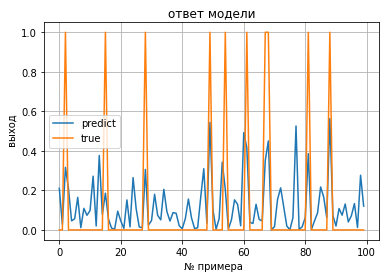

In [314]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

По графику видно, что threshold должен быть существенно ниже 0.5. Получим его лучшее значение ниже:

In [315]:
precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix_ = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_], 
                                                                        fscore[ix_],
                                                                        precision[ix_],
                                                                        recall[ix_]))


Best Threshold=0.224435, F-Score=0.620, Precision=0.526, Recall=0.754


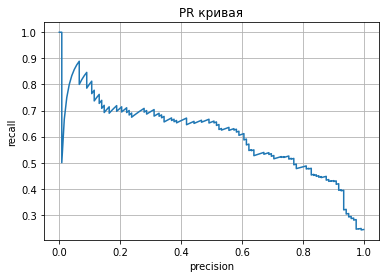

In [316]:
plt.plot(recall,precision )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

In [317]:
import itertools

In [318]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1509  246]
 [  34  211]]


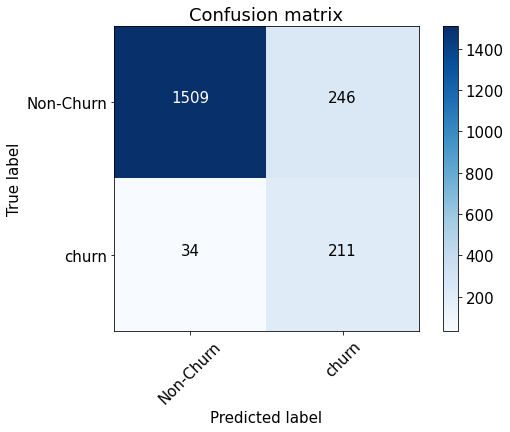

In [319]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [320]:
roc_auc_score_ = roc_auc_score(y_test, preds)
roc_auc_score_

0.9359683702540845

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.

#### Задание 2. 
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [321]:
# Функция для получения вектора пользователя по темам прочитанных статей с использованием МЕДИАНЫ
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector1 = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.median(user_vector1, 0)
    return user_vector1

In [322]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.0,0.0,0.0,0.032394,0.000000,0.017471,0.0,0.000000,...,0.364325,0.000000,0.115058,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
1,u108690,0.0,0.0,0.0,0.0,0.076548,0.087033,0.042212,0.0,0.033540,...,0.415256,0.012589,0.098709,0.0,0.0,0.0,0.033153,0.021517,0.000000,1
2,u108339,0.0,0.0,0.0,0.0,0.117146,0.018618,0.078894,0.0,0.111879,...,0.422970,0.005021,0.033157,0.0,0.0,0.0,0.030230,0.046672,0.006952,1


In [323]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [324]:
logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [325]:
precision1, recall1, thresholds1 = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore1 = (2 * precision1 * recall1) / (precision1 + recall1)

# locate the index of the largest f score
ix1 = np.argmax(fscore1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds1[ix1], 
                                                                        fscore1[ix1],
                                                                        precision1[ix1],
                                                                        recall1[ix1]))

Best Threshold=0.252870, F-Score=0.729, Precision=0.667, Recall=0.803


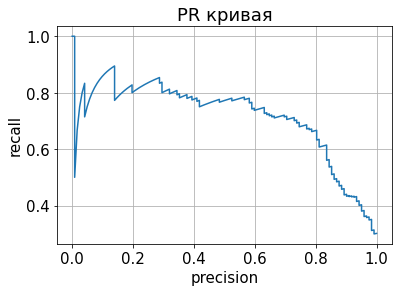

In [326]:
plt.plot(recall1,precision1 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1684   71]
 [  55  190]]


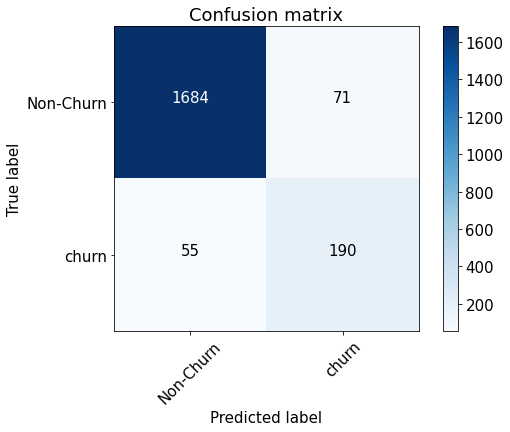

In [327]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [328]:
roc_auc_score1 = roc_auc_score(y_test, preds)
roc_auc_score1

0.9640909355195069

#### Задание 3  
Повторить п.2, но используя уже не медиану, а max

In [329]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.max(user_vector, 0)  
    return user_vector1

In [330]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.000000,0.133599,0.000000,0.262463,0.100472,0.457252,0.000000,0.133603,...,0.626274,0.000000,0.478111,0.142316,0.00000,0.023468,0.112797,0.125400,0.000000,0
1,u108690,0.0,0.000000,0.077536,0.105709,0.117237,0.244951,0.311249,0.022631,0.187064,...,0.534099,0.053167,0.221925,0.011478,0.01438,0.065504,0.216157,0.101189,0.000000,1
2,u108339,0.0,0.015579,0.014990,0.000000,0.296626,0.064767,0.177148,0.028613,0.244891,...,0.526030,0.018151,0.103656,0.000000,0.00000,0.000000,0.136063,0.222549,0.038211,1


In [331]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [332]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)

# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

Best Threshold=0.252870, F-Score=0.729, Precision=0.667, Recall=0.803


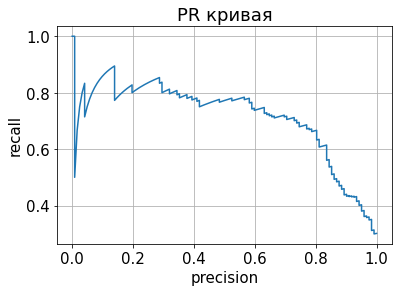

In [333]:
plt.plot(recall2,precision2 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1684   71]
 [  55  190]]


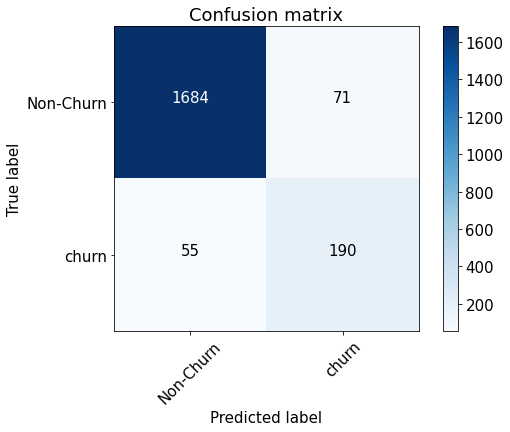

In [334]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [335]:
roc_auc_score2 = roc_auc_score(y_test, preds)
roc_auc_score2

0.9640909355195069

#### Задание 5
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [336]:
evaluation = pd.DataFrame({
    'тип усреднения': ['mean', 'median', 'max'],
    'precision': [precision[ix_], precision1[ix1], precision2[ix2]],
    'recall': [recall[ix_], recall1[ix1], recall2[ix2]],
    'F score': [fscore[ix_], fscore1[ix1], fscore2[ix2]],
    'ROC-AUC score': [roc_auc_score_, roc_auc_score1, roc_auc_score2],
})

evaluation

,тип усреднения,precision,recall,F score,ROC-AUC score
0,mean,0.525714,0.754098,0.619529,0.935968
1,median,0.666667,0.803279,0.728625,0.964091
2,max,0.666667,0.803279,0.728625,0.964091


#### Задание 6 
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

* Наилучшие значения метрик достигаются при разбиении на 20 тем и при взятии **максимального** значения среди вероятностей каждой темы при формировании вектора пользователя. В целом с точки зрения логики, выбор максимального значения среди вероятностей тематик - наиболее удачный.
* Выбирая среднее - сильно падает полтора(recall) и f мера, то есть в таком случае у нас падает качество классификации - мы менее точно предсказываем количество покинувших портал пользователей, пропуская часть пользователей
* Среднее и медиана предполагают возможность снижения вероятности чтения темы, которую пользователь действительно читает (если в случае среднего все вероятности участвуют в формировании результата,то в случае медианы остается только одно значение из середины, а остальные не участвуют вообще, таким образом мы их теряем, то есть теоретическим можем потерять действительно читаемую пользователем тему).